$$
\newcommand{\dd}{\text{d}}
\newcommand{\pdv}[2]{ \frac{\partial #1}{\partial #2}  }
\newcommand{\dv}[2]{ \frac{\dd #1}{\dd #2} }
$$

# Turbulent axisymmetric wake

In this notebook we model the evolution of the center of pressure of a turbulent bluff body wake (the centroid of the base pressure distribution).  See [here](https://doi.org/10.1017/jfm.2014.449) for details on the experimental configuration and calculation of the center of pressure.  The turbulent flow is characterized by a symmetry-breaking instability; the radial coordinate $r(t)$ of the center of pressure is a proxy for the amplitude of the symmetry-breaking.  Analysis of the laminar flow suggests that the dynamics could be approximated with the normal form of a pitchfork bifurcation:
$$
\dot{r} = \lambda r - \mu r^3.
$$

It has [previously been shown](https://doi.org/10.1017/jfm.2015.390) that the turbulent flow can be modeled with a Langevin equation where the drift dynamics are the laminar normal form and the turbulence is parameterized with white noise:
$$
\dot{r} = \lambda r - \mu r^3 + \frac{\sigma^2}{2r} + \sigma w(t),
$$
where $w(t)$ is a Gaussian white noise process and the $1/r$ term arises from the stochastic change of variables to polar coordinates, see Risken (1996) for details.

In [1]:
from time import time

# Numpy
import numpy as np
from numpy.linalg import lstsq
import numpy.random as rng
from numpy import polyfit, polyval

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']    # Default matplotlib colors
#color_list[:2] = ["#000000", "#e66101"]  # Black/red
color_list[:3] = ["#000000", "#5891BF", "#ff7f0e"]  # Black/blue  

# Or use Seaborn colormap
#import seaborn as sns
#color_list = sns.color_palette('muted').as_hex()

cm = mpl.colors.ListedColormap(color_list)

# Scipy
from scipy.optimize import curve_fit, minimize
from scipy.signal import welch
from scipy import sparse, linalg
import scipy.io as sio
from scipy.stats import kurtosis

import sympy

# Custom packages
import utils
import fpsolve

The 2D Cartesian coordinates of the center of pressure are computed from a weighted mean of 64 pressure taps on the back of the bluff body.  The radial coordinate of the center of pressure is precomputed and saved in the `data` folder.  The data matrix actually contains 11 rows, each containing 810,000 samples from an independent experiment. For the sake of simplicity, we just flatten the data matrix.  This is only a problem at the jumps between experiments, which doesn't affect the statistics

In [2]:
# freestream parameters for non-dimensionalization
Uinf = 15              # freestream velocity [m/sec]
Pinf = 0.5*1.2041*15**2  # rho_air = 1.2041 (20C) -> Pinf = 135.4612
D = 196.5              # Diameter of the body [mm]

# Sampling rate
fs = 225  # Hz   
dt = 1/fs

# Load the data
data = sio.loadmat('./data/wake-cop.mat')
cop = data['cop'].flatten()

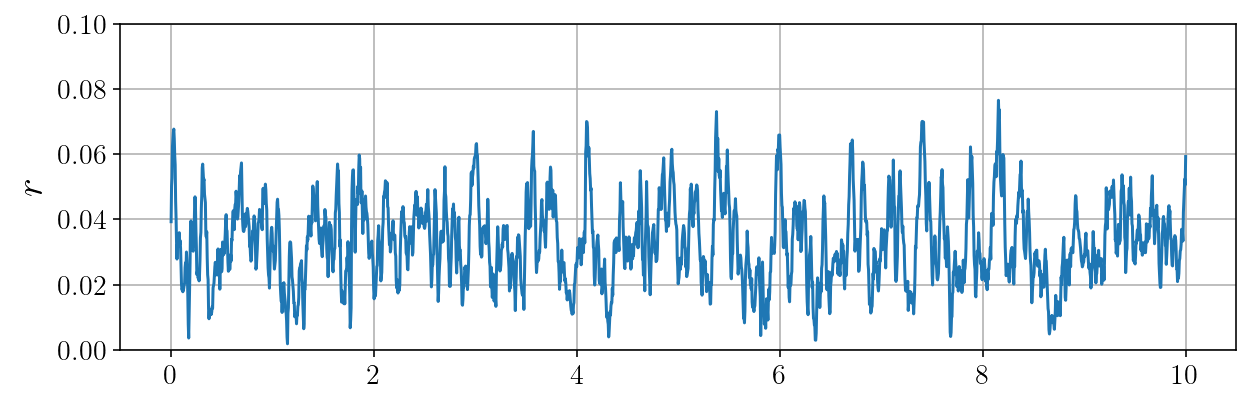

In [3]:
# Example time series
t = dt*np.arange(len(cop))
plt.figure(figsize=(10, 3))

tmax=10

plt.plot(t[t<tmax], cop[t<tmax])
plt.ylim([0, 0.1])
plt.ylabel(r'$r$')
plt.grid()

plt.show()

In [4]:
# Rescale the center of pressure to have mean value of 1
#   This is mainly important for stability of the Monte Carlo simulation later
scale = np.mean(cop)
R = cop/scale

# 1. Fit to steady-state PDF

The solution to the steady-state Fokker-Planck equation can be determined analytically in this case (see text).  One approach (see [Rigas et al](https://doi.org/10.1017/jfm.2015.390)) is to estimate parameters by fitting to the steady-state PDF.

In [5]:
# First we have to compute mean-square displacement to estimate diffusion

# Time lags
n_lags = fs  # lag up to one second
tau = dt*np.arange(1, n_lags)

# Lagged mean square displacement
msd = np.zeros((len(tau)))
for i in range(1, n_lags):
    msd[i-1] = np.mean( (R[i:]-R[:-i])**2)

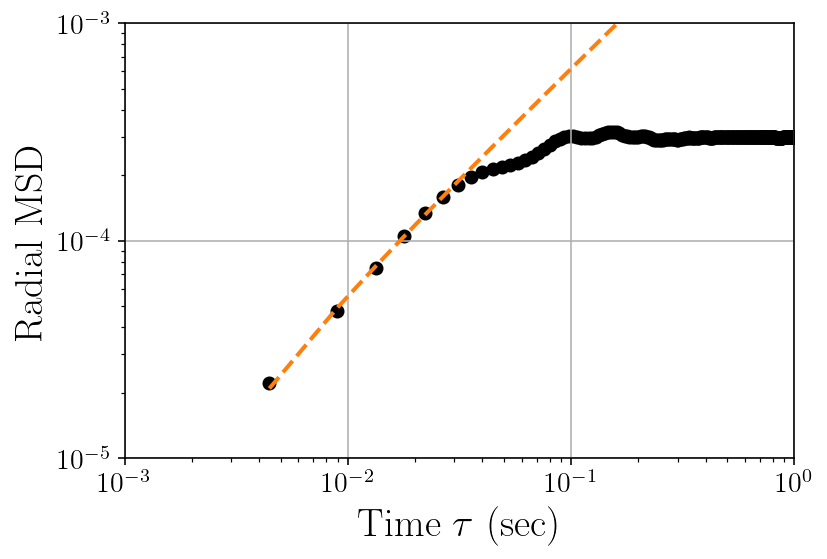

In [6]:
# For additive diffusion we expect approximately linear growth, with slope determined by the diffusion constant

plt.figure(figsize=(6, 4))

# Linear fit for radial displacement
fit_start, fit_stop = 1e-3, 3e-2
to_fit = (tau > fit_start) * (tau < fit_stop)
p_rad = polyfit(tau[to_fit], msd[to_fit], deg=1)
a_pdf = 0.5*p_rad[0]

plt.scatter(tau, msd*scale**2, c='k')
plt.plot(tau, polyval(p_rad, tau)*scale**2, '--',
         c=cm(2), lw=2, label='Linear fit, a={0:0.4f}'.format(a_pdf))

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim([1e-3, 1e0])
plt.ylim([1e-5, 1e-3])
#plt.legend(fontsize=16)
plt.grid()
plt.ylabel('Radial MSD')
plt.xlabel(r'Time $\tau$ (sec)')

plt.show()

[ 0.82653148  1.7595811  -2.51378828]
KL divergence (PDF fit): 0.04592


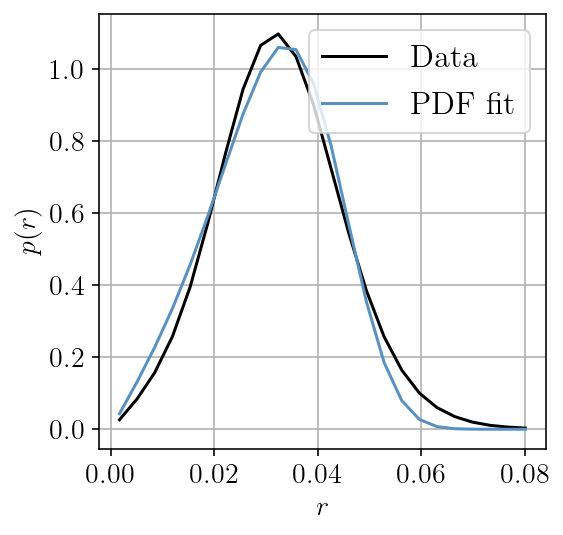

In [7]:
# Now we can estimate the remaining parameters from the steady-state PDF

p_model = lambda r, C, A, B:  C*np.exp( 0.5*A*r**2 + 0.25*B*r**4 + np.log(r) )  # Analytic solution

# Compute the empirical PDF from the experimental data
Nr = 24
r_edges = np.linspace(0, 2.5, Nr+1)  # Histogram bins
dr = r_edges[1]-r_edges[0]
r_centers = (r_edges[:-1]+r_edges[1:])/2  # Center of the histogram bins
pr_hist = np.histogram(R, r_edges, density=True)[0]

popt, pcov = curve_fit(p_model, r_centers, pr_hist)
print(popt)

pr_orig = p_model(r_centers, *popt)
print('KL divergence (PDF fit): {0:0.5f}'.format(utils.kl_divergence(pr_hist, pr_orig, dx=dr)))

# Now we can pull out the different parameters in the model and construct the drift function
lamb_pdf = a_pdf*popt[1]
mu_pdf = a_pdf*popt[2]
f_pdf = lambda r: lamb_pdf*r + mu_pdf*r**3 + a_pdf/r

plt.figure(figsize=(4, 4))
plt.plot(r_centers*scale, pr_hist, c=cm(0), label='Data')
plt.plot(r_centers*scale, pr_orig, c=cm(1), label='PDF fit')
plt.legend(fontsize=16)
plt.xlabel('$r$', fontsize = 14)
plt.ylabel('$p(r)$', fontsize = 14)
plt.grid()
plt.show()

# 2. Langevin regression

First, we have to choose the coarse sampling rate (see App B in the text).  We can demo three ways of doing this:

1. Look for the autocorrelation function to start to decay
2. Plot the kurtosis of the "forcing" as a function of sampling rate and look for it to level off
3. Test the Markov property of the system at different sampling rates

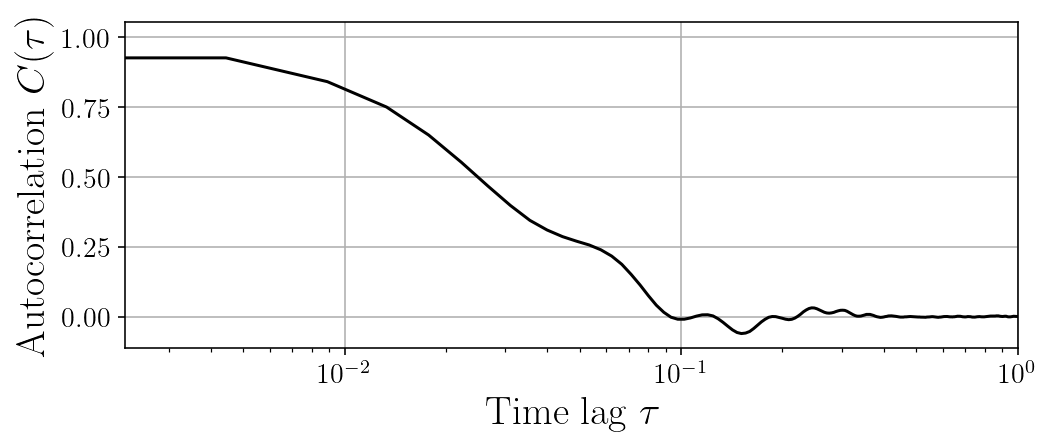

In [8]:
# 1. Autocorrelation function
acf = utils.autocorr_func_1d(R)
tau = dt*np.arange(0, len(R))

plt.figure(figsize=(8, 3))
plt.plot(tau, acf, 'k')
plt.ylabel(r'Autocorrelation $C(\tau)$')
plt.xlabel(r'Time lag $\tau$')

plt.xlim([0.5*dt, 1e0])
plt.gca().set_xscale('log')

plt.grid()
plt.show()

In [9]:
# 2. Mean kurtosis vs lag
lag = np.arange(1, 50)

kurt = np.zeros(lag.shape)
for j in range(len(lag)):
    tau = lag[j]*dt
    dX = (R[lag[j]:] - R[:-lag[j]])/tau  # Step (finite-difference derivative estimate)

    for i in range(Nr):
        # Find where signal falls into this bin
        mask = np.nonzero( (R[:-lag[j]] > r_edges[i]) * (R[:-lag[j]] < r_edges[i+1])[0]
        kurt[j] += kurtosis(dX[mask], fisher=False)

kurt = kurt/Nr # Average over domain
                          
plt.figure(figsize=(8, 3))
plt.plot(dt*lag, kurt, 'k')
plt.gca().set_xscale('log')
plt.xlim([0.5*dt, 1e0])
plt.grid()
plt.xlabel(r'Time lag $\tau$')
plt.ylabel('Kurtosis')
plt.show()

SyntaxError: invalid syntax (<ipython-input-9-3ceddf5de2f9>, line 12)

In [ ]:
# 3. Markov test (in utils.py)
lag = np.round( np.logspace(0, 2.5, 50) ).astype(int)
kl_div = np.array([utils.markov_test(R, delta, N=16) for delta in lag])

In [ ]:
plt.figure(figsize=(8, 3))
plt.gca().set_xscale('log')
plt.plot(dt*lag, kl_div, 'k.')

plt.ylabel(r'$\mathcal{D}_{KL}(\tau)$')
plt.xlabel(r'Sampling time $\tau$')
plt.xlim([0.5*dt, 1e0])
plt.grid()

### Kramers-Moyal average

Based on these results, we'll choose $\tau \approx 4 \times 10^{-2}$, which seems to be a reasonable balance of these criteria.  Now we can compute the conditional finite-time moments:

In [ ]:
lag = 10 # Coarse sampling rate (in timesteps)
tau = lag*dt
print("Tau: {0}".format(tau))

f_KM = np.zeros((Nr))
f_err = np.zeros(f_KM.shape)
a_KM = np.zeros((f_KM.shape))
a_err = np.zeros((f_KM.shape))

dX = (R[lag:] - R[:-lag])/tau  # Step (finite-difference derivative estimate)
dX2 = (R[lag:] - R[:-lag])**2/tau  # Variance

for i in range(Nr):
    # Find where signal falls into this bin
    mask = (R[:-lag] > r_edges[i]) * (R[:-lag] < r_edges[i+1])
    mask_idx = np.nonzero(mask)[0]

    # Conditional mean
    f_KM[i] = np.mean(dX[mask_idx]) # Conditional average
    f_err[i] = np.std(dX[mask_idx])/np.sqrt(len(mask_idx))

    # Conditional variance
    a_KM[i] = 0.5*np.mean(dX2[mask]) # Conditional average
    a_err[i] = np.std(dX2[mask])/np.sqrt(len(mask_idx))

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(r_centers, f_pdf(r_centers), 'k--', label='PDF fit')
plt.plot(r_centers, f_KM, label='Finite-time KM')
plt.gca().fill_between(r_centers, f_KM-3*f_err, f_KM+3*f_err, alpha=0.4)
plt.xlabel('$X_t$', fontsize = 14)
plt.ylabel('Drift', fontsize = 14)
plt.grid()
plt.ylim([-50, 50])
plt.legend()

plt.subplot(122)
plt.plot(r_centers, a_pdf + 0*r_centers, 'k--', label='PDF fit')
plt.plot(r_centers, a_KM, label='Finite-time KM')
plt.gca().fill_between(r_centers, a_KM-3*a_err, a_KM+3*a_err, alpha=0.4)
plt.ylabel('Diffusion', fontsize = 14)
plt.grid()
plt.ylim([0, 20])
plt.legend()

plt.show()

### Optimization with the Fokker-Planck equations

For this example, we will demonstrate the sparse stepwise regression (SSR) approach to model selection.  So we include a variety of potential terms in the drift and diffusion functions and let the algorithm determine the optimal balance of complexity and accuracy.

In [ ]:
def cost(Xi, params):
    """Least-squares cost function for optimization
    Xi - coefficient estimates
    param - inputs to optimization problem: grid points, list of candidate expressions, regularizations, etc.
        W, f_KM, a_KM, x_pts, y_pts, kl_reg, p_hist
    """
    
    # Unpack parameters
    W = params['W']
    
    # Kramers-Moyal coefficients
    f_KM, a_KM = params['f_KM'].flatten(), params['a_KM'].flatten()
    
    fp, afp = params['fp'], params['afp'] # Fokker-Planck solvers
    lib_f, lib_s = params['lib_f'], params['lib_s']  # SINDy libraries for drift and diffusion
    N = params['N']
    
    # Compute drift and diffusion from libraries + coefficients
    a_vals = 0.5*(lib_s @ Xi[lib_f.shape[1]:])**2
    f_vals = lib_f @ Xi[:lib_f.shape[1]]
    if params['radial']:
        f_vals += a_vals/params['x_pts']  # Diffusion-induced drift from polar change of variables
        
    # Solve AFP equation
    afp.precompute_operator(np.reshape(f_vals, N), np.reshape(a_vals, N))
    f_tau, a_tau = afp.solve(params['tau'])
            
    mask = np.nonzero(np.isfinite(f_KM))[0]
    V = np.sum(W[0, mask]*abs(f_tau[mask] - f_KM[mask])**2) \
      + np.sum(W[1, mask]*abs(a_tau[mask] - a_KM[mask])**2)
    
    # PDF constraint
    if params['kl_reg'] > 0:
        p_hist = params['p_hist']
        
        p_est = fp.solve(f_vals, a_vals)
        kl = utils.kl_divergence(p_hist, p_est, dx=fp.dx, tol=1e-6)
        kl = max(0, kl)
        V += params['kl_reg']*kl
        
    return V

In [ ]:
### Build SINDy libraries for SSR
x = sympy.symbols('r')

f_expr = np.array([x**i for i in [1, 3, 5, 7]])  # Polynomial library for drift
s_expr = np.array([x**i for i in np.arange(3)])  # Polynomial library for diffusion

# Convert sympy expressions to library matrices
lib_f = np.zeros([len(f_expr), Nr])
for k in range(len(f_expr)):
    lamb_expr = sympy.lambdify(x, f_expr[k])
    lib_f[k] = lamb_expr(r_centers)

lib_s = np.zeros([len(s_expr), Nr])
for k in range(len(s_expr)):
    lamb_expr = sympy.lambdify(x, s_expr[k])
    lib_s[k] = lamb_expr(r_centers)
    
# Initialize Xi with standard least-squares
Xi0 = np.zeros((len(f_expr) + len(s_expr)))
mask = np.nonzero(np.isfinite(f_KM))[0]
lhs = f_KM
Xi0[:len(f_expr)] = lstsq( lib_f[:, mask].T, lhs[mask], rcond=None)[0]
lhs = np.sqrt(2*a_KM)
Xi0[len(f_expr):] = lstsq( lib_s[:,mask].T, lhs[mask], rcond=None)[0]

print(Xi0)

In [ ]:
# Now we run the SSR loop around the regular Langevin regression optimization problem

# Weights: uncertainties in Kramers-Moyal
W = np.array((f_err.flatten(), a_err.flatten()))
W[np.less(abs(W), 1e-12, where=np.isfinite(W))] = 1e6  # Set zero entries to large weights
W[np.logical_not(np.isfinite(W))] = 1e6                 # Set NaN entries to large numbers (small weights)
W = 1/W  # Invert error for weights
W = W/np.nansum(W.flatten())

# PDF
p_hist = np.histogram(R, r_edges, density=True)[0]

# Adjoint solver
afp = fpsolve.AdjFP(r_centers)

# Forward solver
fp = fpsolve.SteadyFP(Nr, dr)

params = {"W": W, "f_KM": f_KM, "a_KM": a_KM, "Xi0": Xi0,
          "f_expr": f_expr, "s_expr": s_expr,
          "lib_f": lib_f.T, "lib_s": lib_s.T, "N": Nr,
          "kl_reg": 100,
          "fp": fp, "afp": afp, "p_hist": p_hist, "tau": tau,
          "radial": True, "x_pts": r_centers}

# Use anonymous func tion to automatically past the cost function
opt_fun = lambda params: utils.AFP_opt(cost, params)
Xi, V = utils.SSR_loop(opt_fun, params)

In [ ]:
# Model selection based on the cost function from SSR iterations

labels = [r'${0}$'.format(sympy.latex(t)) for t in np.concatenate((f_expr, s_expr))]

active = abs(Xi) > 1e-8

n_terms = len(labels)
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.scatter(np.arange(len(V)), V, c='k')
plt.gca().set_xticks(np.arange(n_terms-1))
plt.gca().set_xticklabels(np.arange(n_terms, 1, -1))
plt.xlabel('Sparsity')
plt.ylabel(r'Cost')
#plt.gca().set_yscale('log')
plt.grid()

plt.subplot(122)
plt.pcolor(active, cmap='bone_r', edgecolors='gray')
plt.gca().set_yticks(0.5+np.arange(n_terms))
plt.gca().set_yticklabels(labels)
plt.gca().set_xticks(0.5+np.arange(n_terms-1))
plt.gca().set_xticklabels(np.arange(n_terms, 1, -1))
plt.xlabel('Sparsity')
plt.ylabel('Active terms')
plt.show()

Based on this, we can see that the model with 4 terms is the optimal balance of sparsity and accuracy.  Adding more terms doesn't improve the accuracy much, while removing any more terms causes the cost function to significantly increase.  The identified model is
\begin{gather}
\dot{r} = \lambda r - \mu r^3 + \frac{\sigma(r)^2}{2r} + \sigma(r) w(t)\\
\sigma(r) = \sigma_0 + \sigma_1 r^2
\end{gather}
This is almost identical to the model proposed by [Rigas et al](https://doi.org/10.1017/jfm.2015.390), but with an additional nonlinear state-dependence in the diffusion.  This additional term improves the correspondence with both the steady-state PDF and the power spectrum, but would have been difficult to identify from a pure PDF-fitting procedure.

In [ ]:
# Select model from the matrix of candidate models (Xi)
n_terms = 4
print(Xi[:, 1-n_terms])
Xi_f = Xi[:len(f_expr), 1-n_terms]
Xi_s = Xi[len(f_expr):, 1-n_terms]

# Construct functions from the sympy expressions
s_sym = utils.sindy_model(Xi_s, s_expr)
a_sym = 0.5*s_sym**2
f_sym = utils.sindy_model(Xi_f, f_expr) + a_sym/x
s_sindy = sympy.lambdify(x, s_sym)
a_sindy = sympy.lambdify(x, a_sym)
f_sindy = sympy.lambdify(x, f_sym)

# Evaluate the functions at the histogram points so we can use the Fokker-Planck solvers to evaluate the model
f_vals = f_sindy(r_centers)
a_vals = a_sindy(r_centers)

# Check if a scalar (happens when library is a constant)
if np.isscalar(a_vals):
    a_vals = a_vals + 0*r_centers
if np.isscalar(f_vals):
    f_vals = f_vals + 0*r_centers
 
# Steady-state solution to the Fokker-Planck equation
pr_fit = fp.solve(f_vals, a_vals)

plt.figure(figsize=(4, 4))
plt.plot(r_centers*scale, pr_hist, c=cm(0), label='Data')
plt.plot(r_centers*scale, pr_fit, c=cm(1), label='Model')
plt.legend(fontsize=16)
plt.xlabel('$r$', fontsize = 14)
plt.ylabel('$p(r)$', fontsize = 14)
plt.grid()
plt.show()


In addition to the asymptotic PDF, we can also check that the proposed model is consistent with the finite-time Kramers-Moyal average.  We do this by solving the adjoint Fokker-Planck equation to correct for finite-time sampling errors.

In [ ]:
# Plot predicted finite-time evolution
afp.precompute_operator(f_vals, a_vals)
f_tau, a_tau = afp.solve(tau)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.errorbar(r_centers[::2], f_KM[::2], f_err[::2], ls='', marker='.', markersize=10, 
             c=cm(0), label=r'K-M  ($\tau = {{{0:0.2f}}}$)'.format(tau))
plt.plot(r_centers, f_vals, c=cm(1), ls='--', lw=2, label=r'Model ($\tau = 0$)')
plt.plot(r_centers, f_tau, c=cm(1), ls='-', lw=2, label=r'Model ($\tau = {{{0:0.2f}}}$)'.format(tau))
plt.title('Drift')
plt.legend(fontsize=14)
plt.xlabel('$r$', fontsize = 20)
plt.ylabel('$f(r)$', fontsize = 20)
plt.grid()
#plt.xlim([-1.5, 1.5])
plt.ylim([-50, 50])


plt.subplot(122)
plt.errorbar(r_centers[::2], a_KM[::2], a_err[::2], ls='', marker='.', markersize=10, 
             c=cm(0), label=r'K-M  ($\tau = {{{0:0.2f}}}$)'.format(tau))
plt.plot(r_centers, a_vals, c=cm(1), ls='--', lw=2, label=r'Model ($\tau = 0$)')
plt.plot(r_centers, a_tau, c=cm(1), ls='-', lw=2, label=r'Model ($\tau = {{{0:0.2f}}}$)'.format(tau))
#plt.legend(fontsize=14)
plt.title('Diffusion')
plt.xlabel('$r$', fontsize = 20)
plt.ylabel('$a(r)$', fontsize = 20)
plt.grid()
#plt.xlim([-1.8, 1.8])
#plt.ylim([0,1.2])

plt.subplots_adjust(wspace=0.3)
plt.show()

# 3. Monte Carlo evaluation of the identified models

In [ ]:
# Monte Carlo test of the PDF fit model

# Time step with Euler-Maruyama
delta_t = dt/10
nsteps = int(1e6)  # How many steps to save

# Time-step with Euler-Maruyama method
x = 1 # Initial value
X_pdf = np.zeros((nsteps))
for i in range(nsteps-1):  # Outer loop: save state
    if i%(nsteps//10) == 0: print(i)
    for j in range(int(dt/delta_t )): # Inner loop: fine time steps
        if x < 0: x = -x
            
        # Choose random numbers but constrain to stay positive to keep r > 0
        increment = -2*x
        count = 0
        while x+increment < 1e-2:
            # Wiener increment (Gaussian white noise)
            w = np.sqrt(2*a_pdf*delta_t)*rng.randn()

            # EM update
            increment = f_pdf(x)*delta_t + w
            count += 1
            if count > 1e3:
                print("Stuck")
                x = np.nan
                break
        x += increment
    if np.isnan(x):
        print("Solution blew up at time t={0}".format(i*dt))
        break
    X_pdf[i+1] = x  # Save current state

In [ ]:
# Monte Carlo test of the Langevin regression model

# Time step with Euler-Maruyama
delta_t = dt/1
nsteps = int(1e6)  # How many steps to save

# Time-step with Euler-Maruyama method
x = 1 # Initial value
X_MC = np.zeros((nsteps))
for i in range(nsteps-1):  # Outer loop: save state
    if i%(nsteps//10) == 0: print(i)
    for j in range(int(dt/delta_t )): # Inner loop: fine time steps
        if x < 0: x=-x
        
        increment = -2*x
        count = 0
        while x+increment < 1e-2:
            # Wiener increment (Gaussian white noise)
            w = np.sqrt(2*a_sindy(x)*delta_t)*rng.randn()

            # EM update
            increment = f_sindy(x)*delta_t + w
            count += 1
            if count > 1e3:
                print("Stuck")
                x = np.nan
                break
        x += increment
    if np.isnan(x):
        print("Solution blew up at time t={0}".format(i*dt))
        break
    X_MC[i+1] = x  # Save current state

In [ ]:
# Welch PSD estimate
freq, psd = welch(R, fs, nperseg=len(R)//256)
St = freq*(D*1e-3)/Uinf 

freq, psd_MC = welch(X_MC, fs, nperseg=len(X_MC)//512)
St_MC = freq*(D*1e-3)/Uinf 

freq, psd_pdf = welch(X_pdf, fs, nperseg=len(X_pdf)//256)
St_pdf = freq*(D*1e-3)/Uinf 

In [ ]:
pr_fit = fp.solve(f_vals, a_vals)

fig = plt.figure(figsize=(12, 3))

gs = mpl.gridspec.GridSpec(1, 3, figure=fig)
ax = fig.add_subplot(gs[0, :2])

plt.semilogx(St, St*psd, c=cm(0), label='Expt')
plt.semilogx(St_pdf, St_pdf*psd_pdf, label='PDF fit', c=cm(2))
plt.semilogx(St_MC, St_MC*psd_MC, label='Model', c=cm(1))

ax.grid()
ax.legend(fontsize=14)
ax.set_ylabel(r'St $\cdot$ PSD', fontsize=20)
#ax.set_ylim([0, 3e-3])
ax.set_xlabel('St', fontsize=20)

ax = fig.add_subplot(gs[0, 2])

ax.plot(r_centers, pr_hist, c=cm(0), label='Data', lw=3)
ax.plot(r_centers, pr_orig, label='PDF fit', lw=2, c=cm(2))
ax.plot(r_centers, pr_fit, label='Langevin regression', lw=2, c=cm(1))
ax.grid()
#ax.legend(fontsize=18)
ax.set_xlabel('$r$', fontsize=20)
ax.set_ylabel('PDF', fontsize=20)

plt.subplots_adjust(wspace=0.4)
plt.show()